In [2]:
#original from: https://github.com/wikibook/pytorch-drl/blob/master/program/5_3and5_4_DQN.ipynb

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym


In [3]:


# 애니메이션을 만드는 함수
# 참고 URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole_DQN.mp4')  # 애니메이션을 저장하는 부분
    display(display_animation(anim, default_mode='loop'))



In [4]:
# 이 코드에서는 namedtuple을 사용한다
# namedtuple을 사용하면 키-값의 쌍 형태로 값을 저장할 수 있다
# 그리고 키를 필드명으로 값에 접근할 수 있어 편리하다
# https://docs.python.jp/3/library/collections.html#collections.namedtuple
# 아래는 사용 예제이다

from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('이름A', 100)

print(Tr_object)  # 출력：tr(name_a='이름A', value_b=100)
print(Tr_object.value_b)  # 출력：100

tr(name_a='이름A', value_b=100)
100


In [5]:


# namedtuple 생성
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))



In [6]:
# 상수 정의
ENV = 'CartPole-v0'  # 태스크 이름
GAMMA = 0.99  # 시간할인율
MAX_STEPS = 200  # 1에피소드 당 최대 단계 수
NUM_EPISODES = 500  # 최대 에피소드 수


In [7]:
#Replay Memory Class: saves the experienced data from the mini-batch learning, saves the transitions
# transition을 저장하기 위한 메모리 클래스

# transition을 저장하기 위한 메모리 클래스


class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # 메모리의 최대 저장 건수
        self.memory = []  # 실제 transition을 저장할 변수
        self.index = 0  # 저장 위치를 가리킬 인덱스 변수

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)을 메모리에 저장'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # 메모리가 가득차지 않은 경우

        # Transition이라는 namedtuple을 사용하여 키-값 쌍의 형태로 값을 저장
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 다음 저장할 위치를 한 자리 뒤로 수정

    def sample(self, batch_size):
        '''batch_size 갯수 만큼 무작위로 저장된 transition을 추출'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''len 함수로 현재 저장된 transition 갯수를 반환'''
        return len(self.memory)

In [8]:
# 에이전트의 두뇌 역할을 하는 클래스, DQN을 실제 수행한다
# Q함수를 딥러닝 신경망 형태로 정의

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # 행동의 가짓수(왼쪽, 오른쪽)를 구함

        # transition을 기억하기 위한 메모리 객체 생성
        self.memory = ReplayMemory(CAPACITY)

        # 신경망 구성
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # 신경망 구조 출력

        # 최적화 기법 선택
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replay로 신경망의 결합 가중치 학습'''

        # -----------------------------------------
        # 1. 저장된 transition 수 확인
        # -----------------------------------------
        # 1.1 저장된 transition의 수가 미니배치 크기보다 작으면 아무 것도 하지 않음
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. 미니배치 생성
        # -----------------------------------------
        # 2.1 메모리 객체에서 미니배치를 추출
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 각 변수를 미니배치에 맞는 형태로 변형
        # transitions는 각 단계 별로 (state, action, state_next, reward) 형태로 BATCH_SIZE 갯수만큼 저장됨
        # 다시 말해, (state, action, state_next, reward) * BATCH_SIZE 형태가 된다
        # 이것을 미니배치로 만들기 위해
        # (state*BATCH_SIZE, action*BATCH_SIZE, state_next*BATCH_SIZE, reward*BATCH_SIZE) 형태로 변환한다
        batch = Transition(*zip(*transitions))

        # 2.3 각 변수의 요소를 미니배치에 맞게 변형하고, 신경망으로 다룰 수 있도록 Variable로 만든다
        # state를 예로 들면, [torch.FloatTensor of size 1*4] 형태의 요소가 BATCH_SIZE 갯수만큼 있는 형태이다
        # 이를 torch.FloatTensor of size BATCH_SIZE*4 형태로 변형한다
        # 상태, 행동, 보상, non_final 상태로 된 미니배치를 나타내는 Variable을 생성
        # cat은 Concatenates(연접)을 의미한다
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # -----------------------------------------
        # 3. 정답신호로 사용할 Q(s_t, a_t)를 계산
        # -----------------------------------------
        # 3.1 신경망을 추론 모드로 전환
        self.model.eval()

        # 3.2 신경망으로 Q(s_t, a_t)를 계산
        # self.model(state_batch)은 왼쪽, 오른쪽에 대한 Q값을 출력하며
        # [torch.FloatTensor of size BATCH_SIZEx2] 형태이다
        # 여기서부터는 실행한 행동 a_t에 대한 Q값을 계산하므로 action_batch에서 취한 행동 a_t가 
        # 왼쪽이냐 오른쪽이냐에 대한 인덱스를 구하고, 이에 대한 Q값을 gather 메서드로 모아온다
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}값을 계산한다 이때 다음 상태가 존재하는지에 주의해야 한다

        # cartpole이 done 상태가 아니고, next_state가 존재하는지 확인하는 인덱스 마스크를 만듬
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        # 먼저 전체를 0으로 초기화
        next_state_values = torch.zeros(BATCH_SIZE)

        # 다음 상태가 있는 인덱스에 대한 최대 Q값을 구한다
        # 출력에 접근하여 열방향 최대값(max(1))이 되는 [값, 인덱스]를 구한다
        # 그리고 이 Q값(인덱스=0)을 출력한 다음
        # detach 메서드로 이 값을 꺼내온다
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        # 3.4 정답신호로 사용할 Q(s_t, a_t)값을 Q러닝 식으로 계산한다
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 결합 가중치 수정
        # -----------------------------------------
        # 4.1 신경망을 학습 모드로 전환
        self.model.train()

        # 4.2 손실함수를 계산 (smooth_l1_loss는 Huber 함수)
        # expected_state_action_values은
        # size가 [minibatch]이므로 unsqueeze하여 [minibatch*1]로 만든다
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 결합 가중치를 수정한다
        self.optimizer.zero_grad()  # 경사를 초기화
        loss.backward()  # 역전파 계산
        self.optimizer.step()  # 결합 가중치 수정

    def decide_action(self, state, episode):
        '''현재 상태에 따라 행동을 결정한다'''
        # ε-greedy 알고리즘에서 서서히 최적행동의 비중을 늘린다
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # 신경망을 추론 모드로 전환
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # 신경망 출력의 최댓값에 대한 인덱스 = max(1)[1]
            # .view(1,1)은 [torch.LongTensor of size 1] 을 size 1*1로 변환하는 역할을 한다

        else:
            # 행동을 무작위로 반환(0 혹은 1)
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 행동을 무작위로 반환(0 혹은 1)
            # action은 [torch.LongTensor of size 1*1] 형태가 된다

        return action

In [9]:
# CartPole 태스크의 에이전트 클래스. 봉 달린 수레 자체라고 보면 된다


class Agent:
    def __init__(self, num_states, num_actions):
        '''태스크의 상태 및 행동의 가짓수를 설정'''
        self.brain = Brain(num_states, num_actions)  # 에이전트의 행동을 결정할 두뇌 역할 객체를 생성

    def update_q_function(self):
        '''Q함수를 수정'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''행동을 결정'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memory 객체에 state, action, state_next, reward 내용을 저장'''
        self.brain.memory.push(state, action, state_next, reward)

In [10]:
# CartPole을 실행하는 환경 역할을 하는 클래스


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 태스크를 설정
        num_states = self.env.observation_space.shape[0]  # 태스크의 상태 변수 수(4)를 받아옴
        num_actions = self.env.action_space.n  # 태스크의 행동 가짓수(2)를 받아옴
        self.agent = Agent(num_states, num_actions)  # 에이전트 역할을 할 객체를 생성

        
    def run(self):
        '''실행'''
        episode_10_list = np.zeros(10)  # 최근 10에피소드 동안 버틴 단계 수를 저장함(평균 단계 수를 출력할 때 사용)
        complete_episodes = 0  # 현재까지 195단계를 버틴 에피소드 수
        episode_final = False  # 마지막 에피소드 여부
        frames = []  # 애니메이션을 만들기 위해 마지막 에피소드의 프레임을 저장할 배열

        for episode in range(NUM_EPISODES):  # 최대 에피소드 수만큼 반복
            observation = self.env.reset()  # 환경 초기화

            state = observation  # 관측을 변환없이 그대로 상태 s로 사용
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # NumPy 변수를 파이토치 텐서로 변환
            state = torch.unsqueeze(state, 0)  # size 4를 size 1*4로 변환

            for step in range(MAX_STEPS):  # 1 에피소드에 해당하는 반복문

                if episode_final is True:  # 마지막 에피소드에서는 각 시각의 이미지를 frames에 저장한다
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  # 다음 행동을 결정

                # 행동 a_t를 실행하여 다음 상태 s_{t+1}과 done 플래그 값을 결정
                # action에 .item()을 호출하여 행동 내용을 구함
                observation_next, _, done, _ = self.env.step(
                    action.item())  # reward와 info는 사용하지 않으므로 _로 처리

                # 보상을 부여하고 episode의 종료 판정 및 state_next를 설정한다
                if done:  # 단계 수가 200을 넘었거나 봉이 일정 각도 이상 기울면 done이 True가 됨
                    state_next = None  # 다음 상태가 없으므로 None으로

                    # 최근 10 에피소드에서 버틴 단계 수를 리스트에 저장
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 도중에 봉이 쓰러졌다면 페널티로 보상 -1을 부여
                        complete_episodes = 0  # 연속 성공 에피소드 기록을 초기화
                    else:
                        reward = torch.FloatTensor([1.0])  # 봉이 서 있는 채로 에피소드를 마쳤다면 보상 1 부여
                        complete_episodes = complete_episodes + 1  # 연속 성공 에피소드 기록을 갱신
                else:
                    reward = torch.FloatTensor([0.0])  # 그 외의 경우는 보상 0을 부여
                    state_next = observation_next  # 관측 결과를 그대로 상태로 사용
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy 변수를 파이토치 텐서로 변환
                    state_next = torch.unsqueeze(state_next, 0)  # size 4를 size 1*4로 변환

                # 메모리에 경험을 저장
                self.agent.memorize(state, action, state_next, reward)

                # Experience Replay로 Q함수를 수정
                self.agent.update_q_function()

                # 관측 결과를 업데이트
                state = state_next

                # 에피소드 종료 처리
                if done:
                    print('%d Episode: Finished after %d steps：최근 10 에피소드의 평균 단계 수 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # 애니메이션 생성 및 저장
                display_frames_as_gif(frames)
                break

            # 10 에피소드 연속으로 195단계를 버티면 태스크 성공
            if complete_episodes >= 10:
                print('10 에피소드 연속 성공')
                episode_final = True  # 다음 에피소드에서 애니메이션을 생성

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 12 steps：최근 10 에피소드의 평균 단계 수 = 1.2
1 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 2.1
2 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 3.0
3 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 4.0
4 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 5.0
5 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 6.0
6 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 7.0
7 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 7.9
8 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 8.8
9 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 9.8
10 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 9.6
11 Episode: Finished after 8 steps：최근 10 에피소드의 평균 단계 수 = 9.5
12 Episode: Finished after 9 steps：최근 10 에피

128 Episode: Finished after 67 steps：최근 10 에피소드의 평균 단계 수 = 43.0
129 Episode: Finished after 32 steps：최근 10 에피소드의 평균 단계 수 = 41.2
130 Episode: Finished after 33 steps：최근 10 에피소드의 평균 단계 수 = 41.8
131 Episode: Finished after 51 steps：최근 10 에피소드의 평균 단계 수 = 43.4
132 Episode: Finished after 90 steps：최근 10 에피소드의 평균 단계 수 = 48.6
133 Episode: Finished after 68 steps：최근 10 에피소드의 평균 단계 수 = 50.7
134 Episode: Finished after 41 steps：최근 10 에피소드의 평균 단계 수 = 49.6
135 Episode: Finished after 94 steps：최근 10 에피소드의 평균 단계 수 = 55.9
136 Episode: Finished after 83 steps：최근 10 에피소드의 평균 단계 수 = 59.7
137 Episode: Finished after 105 steps：최근 10 에피소드의 평균 단계 수 = 66.4
138 Episode: Finished after 143 steps：최근 10 에피소드의 평균 단계 수 = 74.0
139 Episode: Finished after 85 steps：최근 10 에피소드의 평균 단계 수 = 79.3
140 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 96.0
141 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 110.9
142 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 121.9
143 Episode: Finished after 200 s

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


150 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 200.0


ValueError: unknown file extension: .mp4

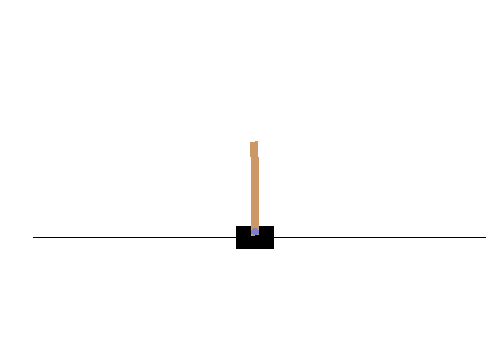

In [11]:
# 실행 엔트리 포인트
cartpole_env = Environment()
cartpole_env.run()